In [3]:
# Import required libraries
import json
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define paths
DATA_DIR = '../data'
JSON_PATH = os.path.join(DATA_DIR, 'WLASL_v0.3.json')
VIDEO_DIR = os.path.join(DATA_DIR, 'videos')

print("Libraries imported successfully.")

Libraries imported successfully.


# WLASL Dataset Exploration

This notebook explores the Word-Level American Sign Language (WLASL) dataset, focusing on:
1. Understanding dataset structure
2. Analyzing class distribution
3. Examining video characteristics (resolution, frame rate, duration)

Let's begin by importing the necessary libraries and setting up our environment.

## 1. Dataset Structure Analysis

Let's start by loading and examining the WLASL dataset structure. The dataset is organized in a JSON file containing metadata and references to video files.

In [4]:
# Load the WLASL dataset
with open(JSON_PATH, 'r') as f:
    wlasl_data = json.load(f)

# Create a list to store all video instances
video_instances = []
for entry in wlasl_data:
    gloss = entry['gloss']  # The sign word/label
    instances = entry['instances']
    for instance in instances:
        video_instances.append({
            'gloss': gloss,
            'video_id': instance['video_id'],
            'fps': instance.get('fps', None),
            'url': instance['url'],
            'split': instance.get('split', None)
        })

# Convert to DataFrame for easier analysis
df = pd.DataFrame(video_instances)

# Display basic information about the dataset
print("Dataset Overview:")
print(f"Number of unique signs (classes): {len(wlasl_data)}")
print(f"Total number of videos: {len(video_instances)}")
print("\nDataset Structure:")
print(df.info())
print("\nFirst few entries:")
print(df.head())

Dataset Overview:
Number of unique signs (classes): 2000
Total number of videos: 21083

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21083 entries, 0 to 21082
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gloss     21083 non-null  object
 1   video_id  21083 non-null  object
 2   fps       21083 non-null  int64 
 3   url       21083 non-null  object
 4   split     21083 non-null  object
dtypes: int64(1), object(4)
memory usage: 823.7+ KB
None

First few entries:
  gloss video_id  fps                                                url  \
0  book    69241   25       http://aslbricks.org/New/ASL-Videos/book.mp4   
1  book    65225   25  https://aslsignbank.haskins.yale.edu/dictionar...   
2  book    68011   25        https://www.youtube.com/watch?v=0UsjUE-TXns   
3  book    68208   25        https://www.youtube.com/watch?v=1QOYOZ3g-aY   
4  book    68012   25        https://www.youtube.com/watch?v=a

## 2. Class Distribution Analysis

Let's analyze how the signs (classes) are distributed in the dataset. This will help us understand if there are any class imbalances.

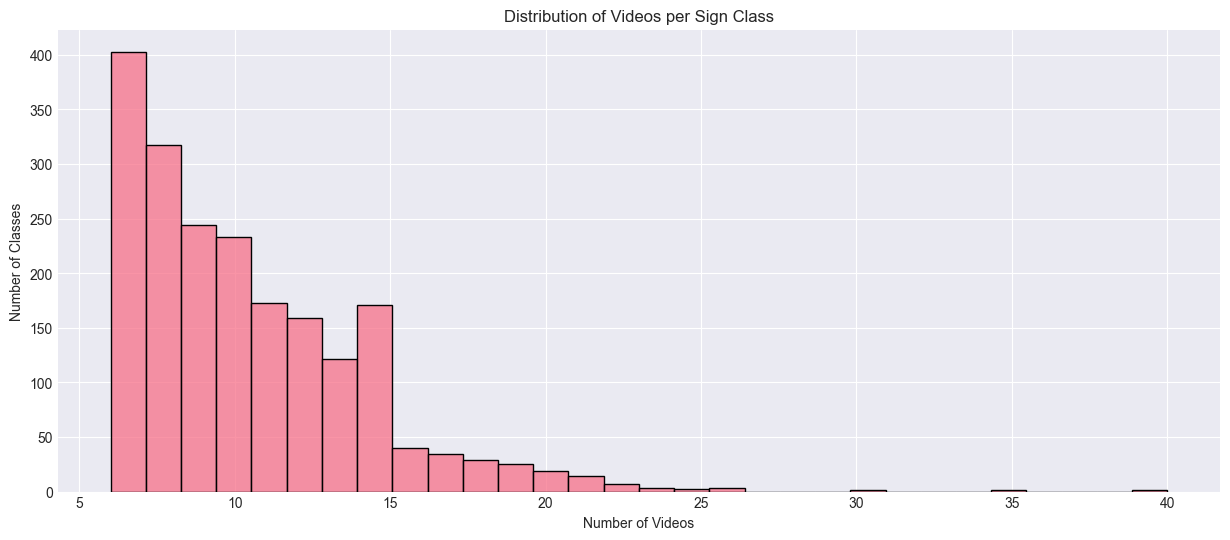

Class Distribution Statistics:
Average videos per class: 10.54
Median videos per class: 10.00
Min videos per class: 6
Max videos per class: 40

Top 10 classes with most videos:
gloss
book        40
drink       35
computer    30
chair       26
before      26
go          26
who         25
clothes     25
candy       24
deaf        23
Name: count, dtype: int64


In [5]:
# Analyze class distribution
class_distribution = df['gloss'].value_counts()

# Plot class distribution
plt.figure(figsize=(15, 6))
sns.histplot(data=class_distribution, bins=30)
plt.title('Distribution of Videos per Sign Class')
plt.xlabel('Number of Videos')
plt.ylabel('Number of Classes')
plt.show()

# Print some statistics about class distribution
print("Class Distribution Statistics:")
print(f"Average videos per class: {class_distribution.mean():.2f}")
print(f"Median videos per class: {class_distribution.median():.2f}")
print(f"Min videos per class: {class_distribution.min()}")
print(f"Max videos per class: {class_distribution.max()}")

# Show top 10 classes with most videos
print("\nTop 10 classes with most videos:")
print(class_distribution.head(10))

## 3. Video Properties Analysis

Now let's analyze the video properties (resolution, frame rate) for a sample of videos in the dataset. We'll create helper functions to extract this information.

In [6]:
def get_video_properties(video_path):
    """Extract video properties using OpenCV"""
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None
        
        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps if fps > 0 else 0
        
        cap.release()
        return {
            'width': width,
            'height': height,
            'fps': fps,
            'frame_count': frame_count,
            'duration': duration
        }
    except Exception as e:
        print(f"Error processing video: {e}")
        return None

# Analyze a sample of videos
video_properties = []
sample_size = min(100, len(os.listdir(VIDEO_DIR)))  # Analyze up to 100 videos
video_files = os.listdir(VIDEO_DIR)[:sample_size]

for video_file in tqdm(video_files, desc="Analyzing videos"):
    video_path = os.path.join(VIDEO_DIR, video_file)
    props = get_video_properties(video_path)
    if props:
        props['video_file'] = video_file
        video_properties.append(props)

# Convert to DataFrame
video_props_df = pd.DataFrame(video_properties)

# Display summary statistics
print("Video Properties Summary:")
print(video_props_df.describe())

Analyzing videos: 100%|██████████| 100/100 [00:01<00:00, 57.92it/s]

Video Properties Summary:
             width       height         fps  frame_count    duration
count   100.000000   100.000000  100.000000   100.000000  100.000000
mean    800.000000   486.400000   29.282553    75.250000    2.574783
std     626.640361   336.277303    3.743791    34.672894    1.183533
min     288.000000   180.000000   23.976024    26.000000    0.867534
25%     288.000000   192.000000   29.970000    42.750000    1.466047
50%     640.000000   400.000000   29.970030    71.000000    2.469136
75%     724.000000   480.000000   30.002133   103.250000    3.342477
max    1920.000000  1080.000000   50.000000   181.000000    6.033333


## 4. Statistical Visualization

Let's create visualizations to better understand the distribution of video properties.

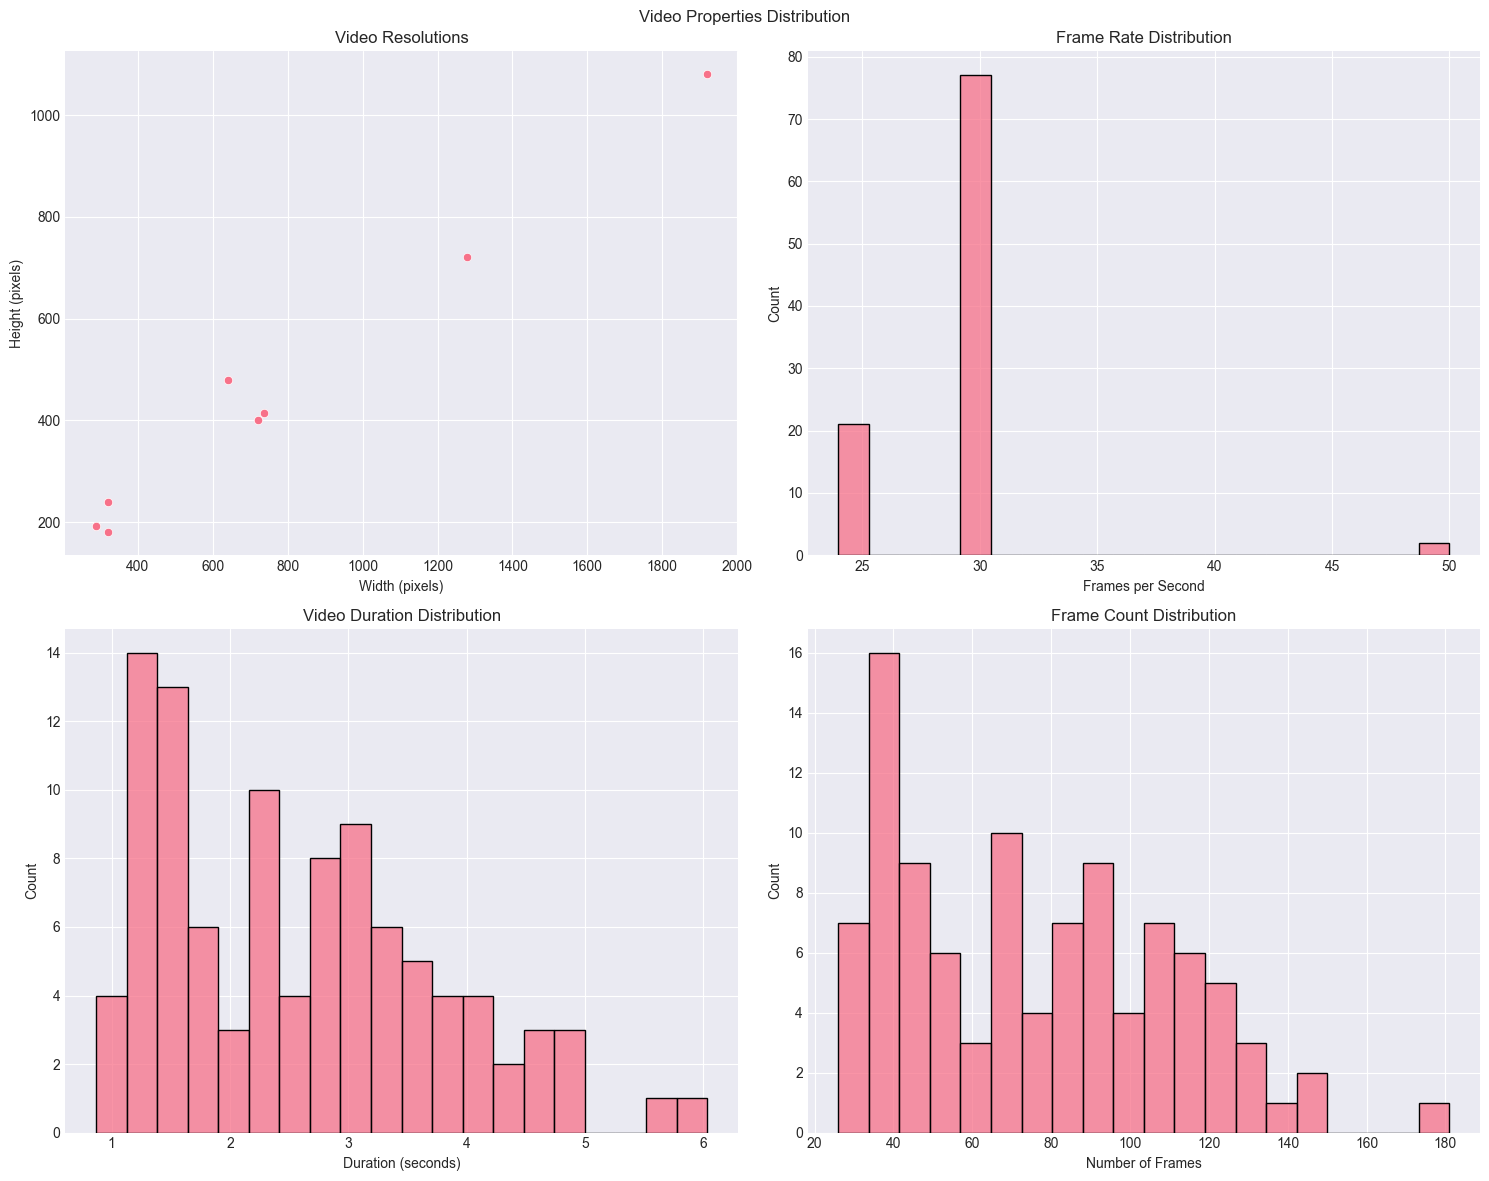


Most common video resolutions:
width  height
288    192       26
1920   1080      22
640    480       17
720    400       16
320    240       15
dtype: int64


In [7]:
# Create visualization grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Video Properties Distribution')

# Resolution distribution
sns.scatterplot(data=video_props_df, x='width', y='height', ax=axes[0,0])
axes[0,0].set_title('Video Resolutions')
axes[0,0].set_xlabel('Width (pixels)')
axes[0,0].set_ylabel('Height (pixels)')

# FPS distribution
sns.histplot(data=video_props_df, x='fps', bins=20, ax=axes[0,1])
axes[0,1].set_title('Frame Rate Distribution')
axes[0,1].set_xlabel('Frames per Second')

# Duration distribution
sns.histplot(data=video_props_df, x='duration', bins=20, ax=axes[1,0])
axes[1,0].set_title('Video Duration Distribution')
axes[1,0].set_xlabel('Duration (seconds)')

# Frame count distribution
sns.histplot(data=video_props_df, x='frame_count', bins=20, ax=axes[1,1])
axes[1,1].set_title('Frame Count Distribution')
axes[1,1].set_xlabel('Number of Frames')

plt.tight_layout()
plt.show()

# Print common resolutions
print("\nMost common video resolutions:")
resolution_counts = video_props_df.groupby(['width', 'height']).size().sort_values(ascending=False)
print(resolution_counts.head())

## words/glosses that have only 1 or 2 videos

Words/glosses with only 1 or 2 videos: 0

Breakdown:
- Words with exactly 1 video: 0
- Words with exactly 2 videos: 0

✓ Good news! All words/glosses in the dataset have at least 3 videos.

Distribution summary:
count    2000.000000
mean       10.541500
std         3.547192
min         6.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        40.000000
Name: num_videos, dtype: float64

Minimum videos per class: 6
Number of classes with minimum videos: 1


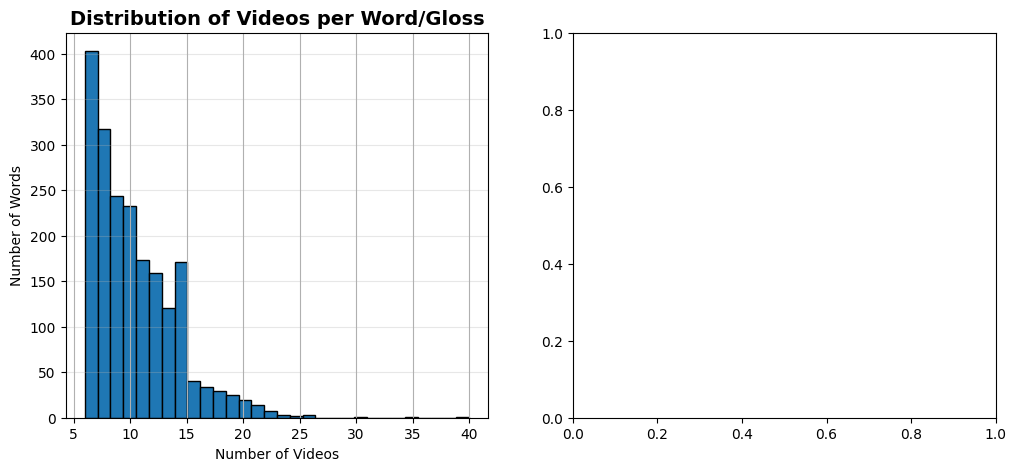

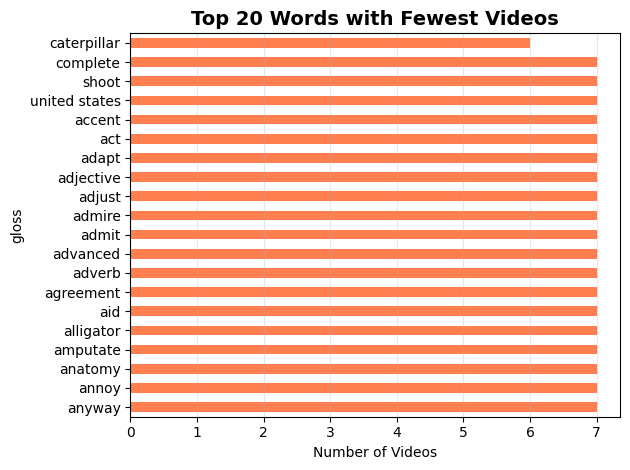

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the WLASL dataset
DATA_DIR = '../data'
JSON_PATH = f'{DATA_DIR}/WLASL_v0.3.json'

with open(JSON_PATH, 'r') as f:
    wlasl_data = json.load(f)

# Count instances per gloss
gloss_counts = []
for entry in wlasl_data:
    gloss = entry['gloss']
    num_instances = len(entry['instances'])
    gloss_counts.append({
        'gloss': gloss,
        'num_videos': num_instances
    })

# Convert to DataFrame
df_counts = pd.DataFrame(gloss_counts)

# Filter words with 1 or 2 videos
words_with_few_videos = df_counts[df_counts['num_videos'] <= 2].sort_values('num_videos')

print(f"Words/glosses with only 1 or 2 videos: {len(words_with_few_videos)}")
print(f"\nBreakdown:")
print(f"- Words with exactly 1 video: {len(words_with_few_videos[words_with_few_videos['num_videos'] == 1])}")
print(f"- Words with exactly 2 videos: {len(words_with_few_videos[words_with_few_videos['num_videos'] == 2])}")

# Check if there are any words with few videos
if len(words_with_few_videos) > 0:
    print("\nList of words with 1 or 2 videos:")
    print("=" * 50)
    print(words_with_few_videos.to_string(index=False))
    
    # Save to CSV for further analysis
    output_path = f'{DATA_DIR}/words_with_few_videos.csv'
    words_with_few_videos.to_csv(output_path, index=False)
    print(f"\nResults saved to: {output_path}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Count of words by video count (1 vs 2)
    video_count_dist = words_with_few_videos['num_videos'].value_counts().sort_index()
    video_count_dist.plot(
        kind='bar', 
        ax=axes[0],
        color=['coral', 'skyblue'][:len(video_count_dist)]
    )
    axes[0].set_title('Distribution of Words with 1 or 2 Videos', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Number of Videos per Word')
    axes[0].set_ylabel('Number of Words')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Sample of the words
    sample_size = min(20, len(words_with_few_videos))
    sample_words = words_with_few_videos.head(sample_size)
    axes[1].barh(sample_words['gloss'], sample_words['num_videos'], color='lightgreen')
    axes[1].set_title(f'Sample: Top {sample_size} Words with Few Videos', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Number of Videos')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ Good news! All words/glosses in the dataset have at least 3 videos.")
    print("\nDistribution summary:")
    print(df_counts['num_videos'].describe())
    
    # Show minimum videos per class
    min_videos = df_counts['num_videos'].min()
    words_with_min = df_counts[df_counts['num_videos'] == min_videos]
    print(f"\nMinimum videos per class: {min_videos}")
    print(f"Number of classes with minimum videos: {len(words_with_min)}")
    
    # Visualize overall distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    df_counts['num_videos'].hist(bins=30, edgecolor='black')
    plt.title('Distribution of Videos per Word/Gloss', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Videos')
    plt.ylabel('Number of Words')
    plt.grid(axis='y', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    df_counts.nsmallest(20, 'num_videos').plot(
        x='gloss', y='num_videos', kind='barh', legend=False, color='coral'
    )
    plt.title('Top 20 Words with Fewest Videos', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Videos')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()